In [17]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [18]:
# Load csv
df = pd.read_csv('../input/cac40-stocks-dataset/preprocessed_CAC40.csv', parse_dates=['Date'])

In [19]:
def load_data(company, start, end):
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

In [20]:
COMPANY = 'Accor'
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)

START_DATE_TEST = END_DATE

In [21]:
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)

In [22]:

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [23]:

prediction_days = 60


x_train = []
y_train = []


for x in range(prediction_days, len(scaled_data)):

    x_train.append(scaled_data[x - prediction_days:x, 0])

    y_train.append(scaled_data[x, 0])


x_train, y_train = np.array(x_train), np.array(y_train)


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [24]:
def LSTM_model():
    model = Sequential()


    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

    model.add(Dropout(0.2))


    model.add(LSTM(units=50, return_sequences=True))

    model.add(Dropout(0.2))


    model.add(LSTM(units=50))

    model.add(Dropout(0.2))


    model.add(Dense(units=1))

    return model

In [25]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [26]:

checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
38/38 [==============================] - 8s 83ms/step - loss: 0.0878
Epoch 2/25
38/38 [==============================] - 3s 81ms/step - loss: 0.0115
Epoch 3/25
38/38 [==============================] - 3s 87ms/step - loss: 0.0104
Epoch 4/25
38/38 [==============================] - 3s 81ms/step - loss: 0.0084
Epoch 5/25
38/38 [==============================] - 3s 81ms/step - loss: 0.0083
Epoch 6/25
38/38 [==============================] - 3s 81ms/step - loss: 0.0085
Epoch 7/25
38/38 [==============================] - 3s 79ms/step - loss: 0.0098
Epoch 8/25
38/38 [==============================] - 3s 82ms/step - loss: 0.0071
Epoch 9/25
38/38 [==============================] - 3s 81ms/step - loss: 0.0077
Epoch 10/25
38/38 [==============================] - 3s 82ms/step - loss: 0.0069
Epoch 11/25
38/38 [==============================] - 3s 81ms/step - loss: 0.0071
Epoch 12/25
38/38 [==============================] - 3s 81ms/step - loss: 0.0063
Epoch 13/25
38/38 [==================

In [27]:

test_data = load_data(
    company=COMPANY,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)


actual_prices = test_data['Close'].values


total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)


model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


model_inputs = model_inputs.reshape(-1, 1)


model_inputs = scaler.transform(model_inputs)

In [28]:

x_test = []


for x in range(prediction_days, len(model_inputs)):

    x_test.append(model_inputs[x-prediction_days:x, 0])


x_test = np.array(x_test)


x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


predicted_prices = model.predict(x_test)


predicted_prices = scaler.inverse_transform(predicted_prices)

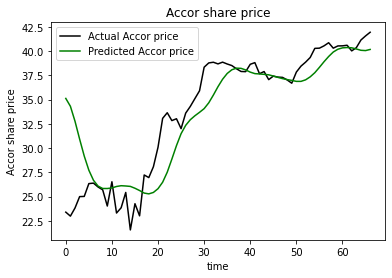

In [29]:

plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")


plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")


plt.title(f"{COMPANY} share price")


plt.xlabel("time")


plt.ylabel(f"{COMPANY} share price")


plt.legend()


plt.show()

In [30]:

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]


real_data = np.array(real_data)


real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))


prediction = model.predict(real_data)


prediction = scaler.inverse_transform(prediction)


print(f"Prediction: {prediction[0][0]}")

Prediction: 40.41305160522461
